# **Problem Statement:-**
**Given:**

1)Number of delivery vehicles.

2)Number of locations & Coordinates of each location where the vehicles has to deliver.

3)A depot where all vehicles start and end their route.


**An optimal route for each vehicle has to be found such that Objective functions are satisfied.**

**Objective Functions:**

1)Total distance travelled by each vehicle - to be minimized.

2)Load Balancing:- Travel distance must be distributed evenly among the vehicles.








In [ ]:
!pip install matplotlib deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
#Required Libraries
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# **Defining Number of Locations & Vehicles**

In [ ]:
#Define the number of locations and vehicles

# Set the seed for reproducibility
random.seed(44)  # You can use any integer value as the seed

num_locations = 20

#Generate random coordinates for the locations
locations = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_locations)]   #This is a list containing corrdinates in tuples
depot = (50, 50)  # Assuming the depot is at the center of a 100x100 area
num_vehicles = 3 #Number of vehicles

In [ ]:
#Lets see the corrdinates of locations which was randomly picked
print(f"Locations: {locations}")

Locations: [(40.853587925449375, 54.19720091045962), (86.20366164792732, 17.666564419544383), (22.51595205781467, 2.909725326811108), (11.665053344286381, 0.8805625887066904), (15.669033508336383, 51.371320850267566), (98.9492910377551, 69.35102614314381), (37.84265711232809, 40.50477353192561), (69.13096284123793, 32.611987261686), (7.355343057826824, 84.1522896906209), (61.721995591408316, 11.200982712964757), (7.006668737991728, 9.462754629553505), (95.89232453363275, 10.771686541376935), (62.531696872284094, 96.95674798615805), (3.5003329400353556, 38.587884676317074), (47.72809704848115, 91.68894603146663), (18.85931650552348, 25.83468686574417), (24.79646412771982, 4.920473727170238), (67.37168204826979, 81.670544057981), (43.63650508959722, 3.7833524782991512), (71.35799802446154, 73.70460170839402)]


# **Genetic Algorithm Setup:** Fitness, Individual & Population

In [ ]:
# Genetic Algorithm Setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))  # Define fitness function to minimize. The two objectives are total distance and balance penalty
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
#Setting up the individuals and population
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_locations), num_locations) #This will be list containing numbers from 0 to num_locations in random order

#Register the "individual" method to create an individual using the indices function
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices) #eg of a individual:- [0,5,8,9,4,1,2,3,6,7] -- this is the order in which locations are visited

#Define the population as a list of individuals
#The population method will generate a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# **Fitness Function**

In [ ]:
import numpy as np
def euclidean_distance(point1, point2):
    #Calculate the Euclidean distance between two points.
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def split_routes(individual, num_vehicles):
    """
    Split the individual's list of locations into routes for each vehicle,
    including any remaining locations in the last vehicle's route.
    """
    #Lets find the number of locations each vehicle has to go to
    avg_route_length = len(individual) // num_vehicles

    # Create the base routes for all vehicles
    routes = [individual[i * avg_route_length:(i + 1) * avg_route_length] for i in range(num_vehicles)]  #routes is a list containing sublists. Each sublist is route of a vehicle


    # If there are remaining locations, add them to the vehicle's routes
    remaining_locations = len(individual) % num_vehicles
    if remaining_locations > 0:
        # Extend the vehicles routes with the remaining locations
        l = len(individual)
        remaining = individual[l-remaining_locations:]  #These will select only the remaining values from the list individual and store it as a list remaining

        for i in range(len(remaining)):
          routes[i].append(remaining[i])

    return routes


# Fitness Function
def evalVRP(individual):
    #Fitness evaluation function
    #Calculate the total distance of routes and the standard deviation among the distances and return (distance, std dev) bcz we want to minimize both distance & std deviation.

    # Split the individual into routes
    routes = split_routes(individual, num_vehicles)

    total_distance = 0 #This will store total distance covered by all vehicles
    distances = []   #This will store distance travelled by each vehicle

    # Calculate the distance for each route
    for route in routes:
        route_distance = 0
        # Vehicle will Start from the depot
        prev_location = depot

        # Add the distance from the depot to the first location and then to the second location...similarly till the last location
        for location_index in route:
            location = locations[location_index]
            route_distance += euclidean_distance(prev_location, location)
            prev_location = location

        # Return to the depot (i.e also calculate distance from the last location to depot)
        route_distance += euclidean_distance(prev_location, depot)

        #route distance for each vehicle will be stored in list named distances
        distances.append(route_distance)

        #Adding route distance of all three vehicles and storing it as total_distance
        total_distance += route_distance


    #Now lets first normalize our route distances for each vehicle
    for i in range(len(routes)):
      distances[i]=distances[i]/len(routes[i])

    # Calculate the standard deviation of the route distances
    std_dev = np.std(distances)

    return total_distance, std_dev


toolbox.register("evaluate", evalVRP)

# **Genetic Operators:** Crossover function, Mutation Function & Selection Function

In [ ]:
# Genetic Operators
toolbox.register("mate", tools.cxPartialyMatched)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

#Mating Methods for sequence of indices
#https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxPartialyMatched
#https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxUniformPartialyMatched
#https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered

#Mutation Methods for Sequences
#https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes

# **Route Plotting Function**

In [ ]:
# Plotting Function
def plot_routes(individual, title="Routes"):
    #Lets Write a function to visualize the routes - just plot the points and lines for each vehicle
    plt.figure()
    # Plot locations as blue dots and the depot as a red square
    for (x, y) in locations:
        plt.plot(x, y, 'bo')
    plt.plot(depot[0], depot[1], 'rs')

    routes = split_routes(individual,num_vehicles)
    # Draw routes for each vehicle
    for i in range(num_vehicles):
      route_of_vehicle = routes[i]
      vehicle_route = [depot] + [locations[j] for j in route_of_vehicle] + [depot]
      plt.plot(*zip(*vehicle_route), '-')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()



# **Running Genetic Algorithms**

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	213   	598.937	0.866491
2  	243   	591.603	0.623237
3  	232   	580.666	0.558346
4  	233   	572.519	0.623237
5  	218   	558.892	0.623237
6  	213   	555.542	0.0520406
7  	233   	546.996	0.0520406
8  	219   	539.203	0.483682 
9  	209   	529.208	0.483682 
10 	224   	517.743	0.329042 
11 	230   	522.995	0.580061 
12 	230   	517.709	0.508408 
13 	217   	500.505	0.615765 
14 	231   	506.416	0.692497 
15 	250   	507.882	0.640806 
16 	238   	494.069	0.0906663
17 	236   	483.73 	0.633212 
18 	225   	488.564	0.633212 
19 	225   	479.301	0.633212 
20 	209   	463.585	0.633212 
21 	232   	462.268	0.221743 
22 	237   	454.324	0.495587 
23 	217   	430.493	0.495587 
24 	227   	396.115	0.495587 
25 	246   	369.466	1.21555  
26 	233   	361.754	0.551412 
27 	219   	360.123	2.33153  
28 	229   	355.423	1.10076  
29 	223   	352.017	0.452269 
30 	238   	349.068	0.643032 
31 	225   	338.779	0.783813 
32 	221   	338.648	1.24519  
33 	243   	331.843	0.

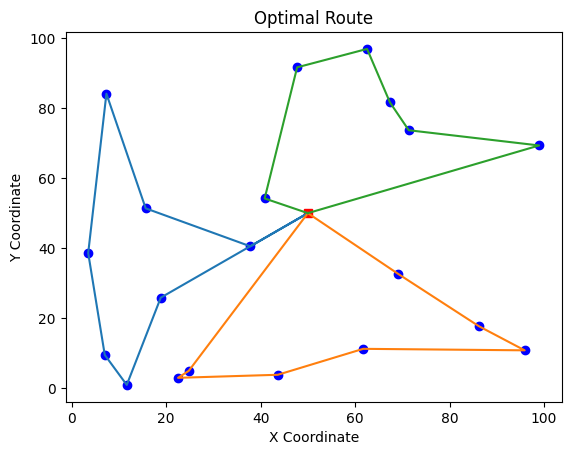

In [ ]:
# Running the Genetic Algorithm
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 200, stats=stats, halloffame=hof)
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results


gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	213   	598.937	0.866491
2  	243   	591.603	0.623237
3  	232   	580.666	0.558346
4  	233   	572.519	0.623237
5  	218   	558.892	0.623237
6  	213   	555.542	0.0520406
7  	233   	546.996	0.0520406
8  	219   	539.203	0.483682 
9  	209   	529.208	0.483682 
10 	224   	517.743	0.329042 
11 	230   	522.995	0.580061 
12 	230   	517.709	0.508408 
13 	217   	500.505	0.615765 
14 	231   	506.416	0.692497 
15 	250   	507.882	0.640806 
16 	238   	494.069	0.0906663
17 	236   	483.73 	0.633212 
18 	225   	488.564	0.633212 
19 	225   	479.301	0.633212 
20 	209   	463.585	0.633212 
21 	232   	462.268	0.221743 
22 	237   	454.324	0.495587 
23 	217   	430.493	0.495587 
24 	227   	396.115	0.495587 
25 	246   	369.466	1.21555  
26 	233   	361.754	0.551412 
27 	219   	360.123	2.33153  
28 	229   	355.423	1.10076  
29 	223   	352.017	0.452269 
30 	238   	349.068	0.643032 
31 	225   	338.779	0.783813 
32 	221   	338.648	1.24519  
33 	243   	331.843	0.

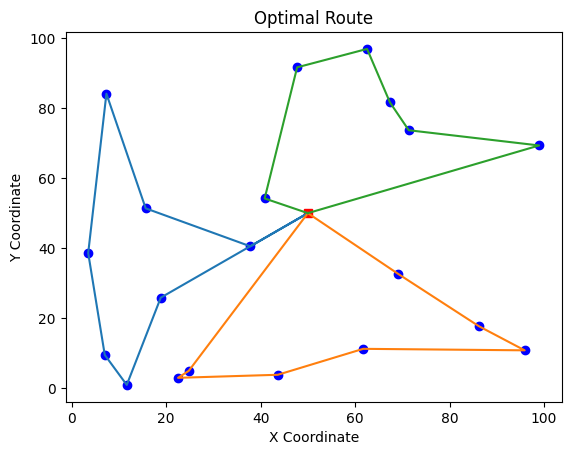

In [ ]:
# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 500, stats=stats, halloffame=hof)
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

# **Trying out different crossover functions**

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	235   	609.723	0.313183
2  	217   	600.407	0.241934
3  	229   	593.259	0.130897
4  	234   	597.453	0.421795
5  	231   	593.001	0.669264
6  	244   	597.595	0.695589
7  	215   	592.258	0.409273
8  	233   	584.758	0.642037
9  	225   	587.184	0.848714
10 	240   	596.829	0.1988  
11 	226   	589.687	0.1988  
12 	236   	592.155	0.579101
13 	230   	582.811	0.233707
14 	229   	589.265	0.498979
15 	221   	584.82 	0.843602
16 	220   	581.689	0.138283
17 	232   	578.454	0.561224
18 	218   	575.206	0.561224
19 	237   	581.515	0.561224
20 	235   	578.496	0.539397
21 	229   	579.337	0.762202
22 	237   	577.943	0.69392 
23 	228   	573.397	0.69392 
24 	219   	572.686	0.670276
25 	243   	579.689	0.69392 
26 	238   	571.996	0.37044 
27 	222   	561.087	0.633049
28 	229   	567.844	0.306836
29 	239   	573.17 	0.314315
30 	217   	576.066	0.314315
31 	230   	570.293	0.190031
32 	239   	571.091	0.908438
33 	220   	565.581	0.17769 
34 	229   	568.052	0

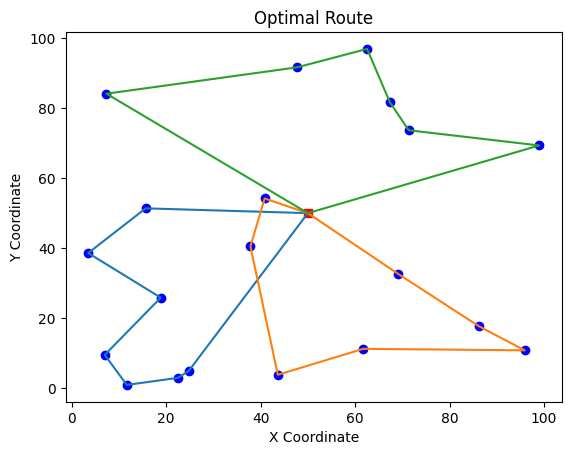

In [ ]:
#Now lets change the crossover function from partialymatched to uniform partialy matched
toolbox.register("mate", tools.cxUniformPartialyMatched,indpb=0.5)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 500, stats=stats, halloffame=hof)
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results


gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	232   	602.267	0.72856 
2  	240   	578.26 	0.272832
3  	234   	569.045	0.139848
4  	222   	559.8  	0.462976
5  	222   	546.267	0.248311
6  	209   	539.476	0.472443
7  	232   	532.084	0.792308
8  	227   	523.642	0.57349 
9  	215   	516.899	0.437078
10 	219   	517.409	0.66373 
11 	229   	506.435	0.474834
12 	228   	501.712	0.588415
13 	224   	500.082	0.790088
14 	232   	497.448	0.770205
15 	247   	500.331	0.370394
16 	226   	489.035	0.370394
17 	232   	489.921	0.256687
18 	220   	480.567	0.382545
19 	226   	482.505	0.344632
20 	224   	483.489	0.462158
21 	243   	482.8  	0.428634
22 	249   	488.189	0.67303 
23 	216   	473.158	0.61839 
24 	235   	472.624	0.0561783
25 	255   	477.903	0.510483 
26 	232   	465.692	0.153838 
27 	231   	463.023	0.128781 
28 	229   	466.239	0.474699 
29 	224   	464.75 	0.474699 
30 	222   	463.589	0.383917 
31 	243   	463.899	0.474699 
32 	228   	460.454	0.474699 
33 	243   	453.215	0.353766 
34 	239   

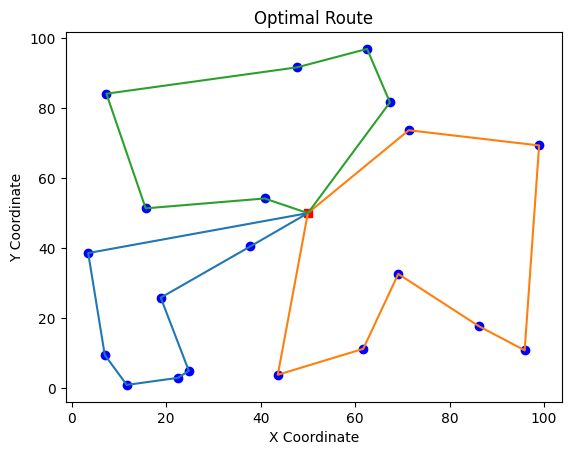

In [ ]:
#Now lets change the crossover function to ordered
toolbox.register("mate", tools.cxOrdered)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 500, stats=stats, halloffame=hof)
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

# **Exploitation**

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	286   	622.964	0.377085
2  	271   	616.754	0.843682
3  	279   	620.526	0.0650586
4  	277   	614.103	0.399754 
5  	270   	609.06 	0.886613 
6  	272   	608.208	0.583665 
7  	274   	608.682	0.741406 
8  	275   	613.118	0.869825 
9  	279   	604.492	1.25969  
10 	285   	607.88 	0.785683 
11 	263   	604.556	1.08081  
12 	264   	606.962	0.274274 
13 	270   	608.79 	0.333914 
14 	276   	613.613	0.703773 
15 	277   	610.641	0.406588 
16 	274   	608.006	0.468851 
17 	275   	605.068	0.678159 
18 	272   	607.694	0.178297 
19 	281   	611.382	0.158289 
20 	277   	610.332	0.158289 
21 	270   	612.503	0.416621 
22 	276   	612.7  	0.474368 
23 	279   	612.194	0.593468 
24 	265   	606.76 	0.507667 
25 	264   	609.473	0.302856 
26 	271   	613.113	0.127874 
27 	284   	604.905	0.385595 
28 	269   	601.829	0.0741401
29 	272   	607.406	0.351209 
30 	277   	610.629	0.414378 
31 	264   	606.687	0.893791 
32 	275   	609.615	0.111703 
33 	279   	605.354

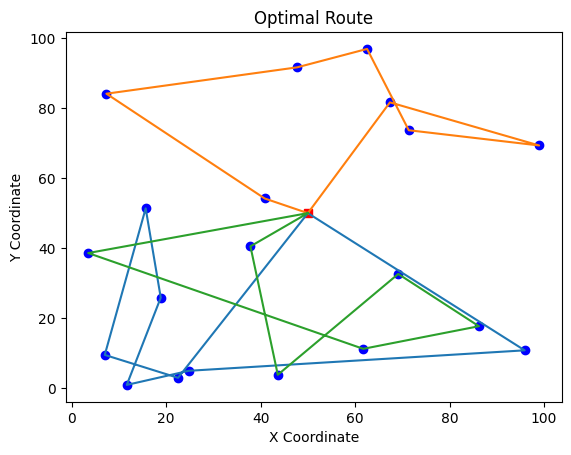

In [ ]:
#Out of all the three crossover functions we tried, uniform partialy matched worked the best so we will keep it
#AND we will keep the crossover probability to 0.9(veryhigh) and keep the mutation probability to 0.1(verylow) (Leading to EXPLOITATION)

toolbox.register("mate", tools.cxUniformPartialyMatched,indpb=0.5)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.9, 0.1, 500, stats=stats, halloffame=hof)  #0.9-crossover prob & 0.1-Mutation prob & running for 500 generations
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

# **Exploration**

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	266   	596.229	0.438022
2  	258   	579.946	0.356516
3  	257   	569.679	0.356516
4  	252   	561.328	0.636061
5  	249   	546.296	0.798878
6  	255   	539.622	0.0917652
7  	263   	536.933	0.572084 
8  	249   	528.822	1.09542  
9  	260   	519.482	0.347854 
10 	268   	508.693	1.12422  
11 	253   	498.032	0.373742 
12 	263   	491.991	0.619468 
13 	262   	488.412	1.09662  
14 	262   	483.779	0.575615 
15 	256   	481.492	0.844135 
16 	266   	475.61 	0.971363 
17 	259   	471.627	0.536132 
18 	259   	465.564	0.59404  
19 	255   	464.88 	0.407343 
20 	258   	465.494	0.538596 
21 	267   	461.895	0.592057 
22 	246   	468.787	0.149213 
23 	263   	474.332	0.609873 
24 	266   	465.808	0.3973   
25 	247   	466.555	0.86749  
26 	252   	455.905	0.660384 
27 	270   	455.729	0.580486 
28 	268   	456.219	0.282385 
29 	263   	463.161	0.376682 
30 	260   	454.422	0.326417 
31 	251   	447.065	0.359654 
32 	253   	437.886	0.443333 
33 	253   	441.204	0.

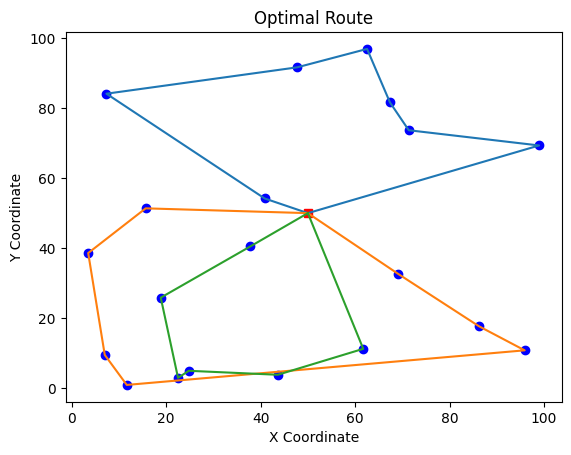

In [ ]:
#Here we will keep the crossover probability low (0.3) and keep the mutation probability high (0.8) (Leading to EXPLORATION)

toolbox.register("mate", tools.cxUniformPartialyMatched,indpb=0.5)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.3, 0.8, 500, stats=stats, halloffame=hof)  #0.3-crossover prob & 0.8-Mutation prob & running for 500 generations
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

# **Finding the balance between Exploration & Exploitation**

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	227   	606.109	0.189712
2  	229   	595.781	0.299606
3  	235   	588.099	0.151513
4  	237   	589.878	0.576367
5  	237   	585.072	0.27355 
6  	225   	578.411	0.338765
7  	221   	576.46 	0.723086
8  	236   	575.29 	0.561313
9  	216   	556.391	0.0913396
10 	234   	560.615	0.912865 
11 	246   	554.242	0.494104 
12 	223   	541.34 	0.494104 
13 	230   	525.987	0.354767 
14 	213   	505.876	0.494104 
15 	230   	481.367	0.176848 
16 	244   	453.213	0.176848 
17 	218   	429.234	0.176848 
18 	228   	419.498	0.184632 
19 	222   	413.696	0.176848 
20 	220   	408.155	0.184632 
21 	227   	404.124	0.184632 
22 	237   	399.668	0.422383 
23 	235   	397.259	0.147817 
24 	241   	393.101	0.147817 
25 	215   	388.024	1.1208   
26 	236   	381.21 	1.62768  
27 	242   	380.128	0.531632 
28 	243   	371.537	1.42969  
29 	222   	373.462	1.06626  
30 	220   	361.307	1.72049  
31 	229   	365.716	0.650099 
32 	219   	368.617	0.739944 
33 	235   	362.159	0.511

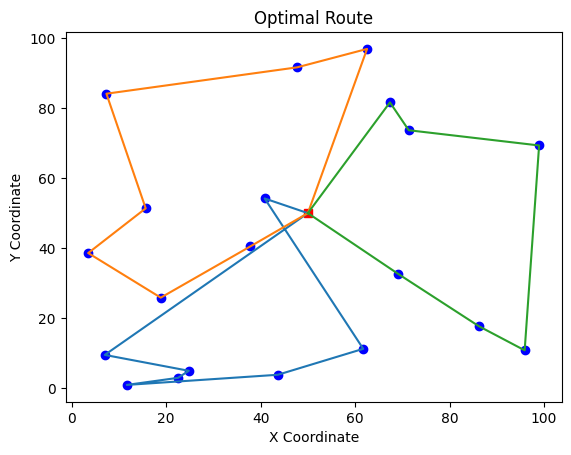

In [ ]:
#Trying to find balance between exploration and exploitation
#crossover probability low = 0.6 and mutation probability = 0.4

toolbox.register("mate", tools.cxUniformPartialyMatched,indpb=0.5)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.6, 0.4, 500, stats=stats, halloffame=hof)  #0.6-crossover prob & 0.4-Mutation prob & running for 500 generations
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

gen	nevals	avg    	min     
0  	300   	628.238	0.931815
1  	235   	609.723	0.313183
2  	217   	600.407	0.241934
3  	229   	593.259	0.130897
4  	234   	597.453	0.421795
5  	231   	593.001	0.669264
6  	244   	597.595	0.695589
7  	215   	592.258	0.409273
8  	233   	584.758	0.642037
9  	225   	587.184	0.848714
10 	240   	596.829	0.1988  
11 	226   	589.687	0.1988  
12 	236   	592.155	0.579101
13 	230   	582.811	0.233707
14 	229   	589.265	0.498979
15 	221   	584.82 	0.843602
16 	220   	581.689	0.138283
17 	232   	578.454	0.561224
18 	218   	575.206	0.561224
19 	237   	581.515	0.561224
20 	235   	578.496	0.539397
21 	229   	579.337	0.762202
22 	237   	577.943	0.69392 
23 	228   	573.397	0.69392 
24 	219   	572.686	0.670276
25 	243   	579.689	0.69392 
26 	238   	571.996	0.37044 
27 	222   	561.087	0.633049
28 	229   	567.844	0.306836
29 	239   	573.17 	0.314315
30 	217   	576.066	0.314315
31 	230   	570.293	0.190031
32 	239   	571.091	0.908438
33 	220   	565.581	0.17769 
34 	229   	568.052	0

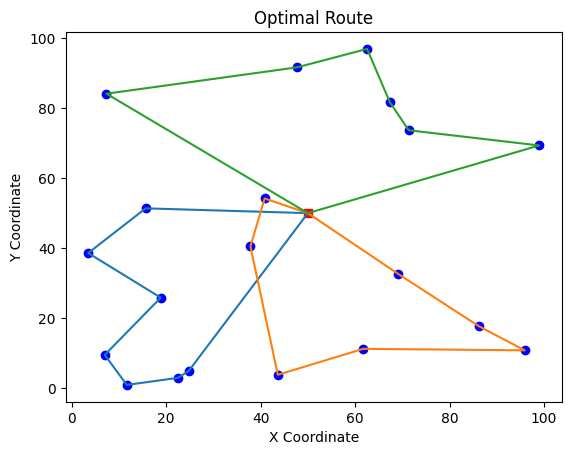

In [ ]:
#This was the perfect balance that we have found out in the earlier code also

toolbox.register("mate", tools.cxUniformPartialyMatched,indpb=0.5)  # Register the crossover function suitable for permutation-based representation
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # Register the mutation function to shuffle indices with a 5% chance per index
toolbox.register("select", tools.selTournament, tournsize=3)  # Register the selection function using tournament selection

# Running the Genetic Algorithm for 500 iterations
def main():
    random.seed(42)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, 0.7, 0.2, 500, stats=stats, halloffame=hof)  #0.7-crossover prob & 0.2-Mutation prob & running for 500 generations
    #Refer eaSimple here - https://deap.readthedocs.io/en/master/api/algo.html

    # Plot the best route found
    plot_routes(hof[0], "Optimal Route")
    return pop, stats, hof

if __name__ == "__main__":
  main()
    # Call the main function, run the algorithm and print the results

**Results:** In the first generation:- Average distance was 628.238	& standard deviation was 0.931815. At 500th generation:- Average distance was 298.36 and standard deviation was 0.469788. That is 52.5% reduction in average travel distance & 49.5% reduction in standard deviation.